## Initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
bs = 256

In [4]:
data_path = Config.data_path()
lang = 'nl'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Download wikipedia data

In [5]:
# from nlputils import split_wiki,get_wiki

In [6]:
# get_wiki(path, lang)

In [7]:
path.ls()

[PosixPath('/storage/nlwiki/wikiextractor'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles.xml'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles-small.xml.bz2'),
 PosixPath('/storage/nlwiki/.ipynb_checkpoints'),
 PosixPath('/storage/nlwiki/nlwiki'),
 PosixPath('/storage/nlwiki/download'),
 PosixPath('/storage/nlwiki/docs_small'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/storage/nlwiki/docs_smallx1'),
 PosixPath('/storage/nlwiki/110kDBRD_v2.tgz'),
 PosixPath('/storage/nlwiki/docs_smallx10'),
 PosixPath('/storage/nlwiki/export.pkl'),
 PosixPath('/storage/nlwiki/nlwiki-latest-pages-articles-small.xml'),
 PosixPath('/storage/nlwiki/docs'),
 PosixPath('/storage/nlwiki/110kDBRD'),
 PosixPath('/storage/nlwiki/docs_minus_textfiles'),
 PosixPath('/storage/nlwiki/docs_smallx3'),
 PosixPath('/storage/nlwiki/docs_smallx1.tar.bz2'),
 PosixPath('/storage/nlwiki/models'),
 PosixPath('/storage/nlwiki/log')]

### Split in separate files

In [8]:
dest = path/'docs_smallx10'

In [9]:
dest.ls()[:5]

[PosixPath('/storage/nlwiki/docs_smallx10/Theophanu.txt'),
 PosixPath('/storage/nlwiki/docs_smallx10/Isis (jazzrockband).txt'),
 PosixPath('/storage/nlwiki/docs_smallx10/Darren Ferguson.txt'),
 PosixPath('/storage/nlwiki/docs_smallx10/Gerson Fehrenbach.txt'),
 PosixPath('/storage/nlwiki/docs_smallx10/Lodewijk van Bourbon-Soissons.txt')]

## Create databunch for language model

In [10]:
data = (TextList.from_folder(dest)
       .split_by_rand_pct(0.1, seed=42)
       .label_for_lm()
       .databunch(bs=bs, num_workers=1))
data.save(f'{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

(60000, 18393)

In [23]:
vocab_file = open(r'/storage/nlwiki/docs_smallx10/nl_databunch.vocab',"w")
for line in data.vocab.itos:
    vocab_file.write(line + "\n") 
vocab_file.close()

## Train language model

In [12]:
data = load_data(dest, f'{lang}_databunch', bs=bs, num_workers=1)

In [13]:
# data.train_ds[:1]

In [14]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()
learn = language_model_learner(data, AWD_LSTM, drop_mult=1.0, pretrained=False)

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


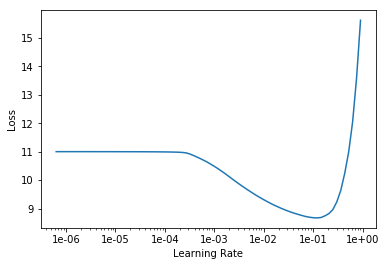

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 1e-2

In [18]:
# learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

In [19]:
learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))
# learn.fit_one_cycle(4, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.453875,4.279010,0.310232,12:11
1,3.901767,3.773496,0.338771,12:13
2,3.800572,3.655917,0.346019,12:13
3,3.682960,3.562868,0.353350,12:14
4,3.602154,3.492790,0.359497,12:14
5,3.495306,3.424704,0.365913,12:14
6,3.425220,3.367112,0.371583,12:14
7,3.339845,3.323453,0.376249,12:14
8,3.261768,3.300972,0.379128,12:13
9,3.199531,3.297324,0.379400,12:14


In [20]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
# learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [ ]:
TEXT = "In zijn laatste roman"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn.predict?

In [ ]:
# learn = language_model_learner(data, AWD_LSTM, drop_mult=1., 
#                                   path = path, 
#                                   pretrained_fnames=lm_fns)
learn.export()

In [ ]:
TEXT = '''Albert Einstein

Albert Einstein'''
N_WORDS = 500
N_SENTENCES = 1

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
data_path